### 패키지 로딩

In [1]:
import time; import random; import datetime
import warnings
warnings.filterwarnings("ignore")


import os
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt


%matplotlib inline

import contextlib
import wave 

import scipy

import librosa
import librosa.display
from glob import glob
from scipy.io import wavfile


from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

 

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, Dropout, MaxPooling2D, Activation,
    Flatten, Dense, Input, Concatenate, LeakyReLU, Add, AveragePooling2D, ReLU, MaxPool2D

)

from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import LearningRateScheduler

import cv2

### wave plot(파형 그래프)

Text(0.5, 1.0, 'Waveform')

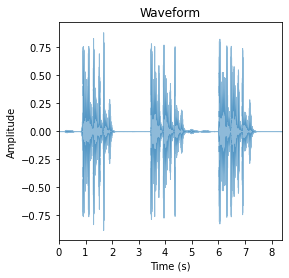

In [2]:
sig, sr = librosa.load('C:/Users/admin/corona_contest/public_dataset/00a4e142-2ae1-401e-8319-837e512b1281.wav', sr=16000)

plt.figure(figsize=(4,4))
librosa.display.waveplot(sig, sr, alpha=0.5)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform")

### 파형 자르기 연습중...! 성공하길

In [3]:
from pydub import AudioSegment
from pydub.silence import split_on_silence

sig, sr = librosa.load('C:/Users/admin/corona_contest/public_dataset/00a4e142-2ae1-401e-8319-837e512b1281.wav', sr=16000)
yt,idx = librosa.effects.trim(sig, top_db = 0.4)
yt2,idx2 = librosa.effects.trim(yt, top_db = 0.01)

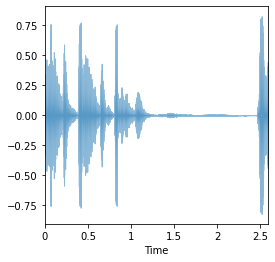

In [4]:
plt.figure(figsize=(4,4))
librosa.display.waveplot(yt2, sr, alpha=0.5)

### 푸리에 변환 그래프

Text(0.5, 1.0, 'Power spectrum')

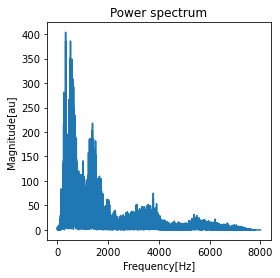

In [5]:
# Fourier -> Spectrum

fft = np.fft.fft(sig)

magnitude = np.abs(fft) 

f = np.linspace(0,sr,len(magnitude))

left_spectrum = magnitude[:int(len(magnitude) / 2)]
left_f = f[:int(len(magnitude) / 2)]

plt.figure(figsize=(4,4))
plt.plot(left_f, left_spectrum)
plt.xlabel("Frequency[Hz]")
plt.ylabel("Magnitude[au]")
plt.title("Power spectrum")

### STFT를 사용하는 스펙트로그램

Text(0.5, 1.0, 'Spectrogram (dB)')

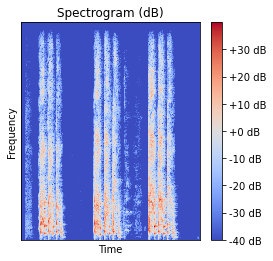

In [6]:
# STFT -> spectrogram

hop_length = 512
n_fft = 1024

hop_length_duration = float(hop_length) / sr
n_fft_duration = float(n_fft) / sr

stft = librosa.stft(sig, n_fft=n_fft, hop_length=hop_length)

magnitude = np.abs(stft)

log_spectrogram = librosa.amplitude_to_db(magnitude)

plt.figure(figsize=(4,4))
librosa.display.specshow(log_spectrogram, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram (dB)")

### 메타데이터 정보 가져오기

In [17]:
metadata = pd.read_csv('C:/Users/admin/corona_contest/metadata_compiled.csv').iloc[:,:10]

In [37]:
# status 결측치 삭제
metadata_re = metadata.dropna(subset=['status']).reset_index(drop=True)

is_cough = metadata_re['cough_detected'] > 0.5
metadata_res = metadata_re[is_cough].reset_index(drop=True)

In [38]:
# 레이블 있는 wav 파일 제외 리스트에 이름 저장
files = 'C:/Users/admin/corona_contest/public_dataset/' + metadata_res['uuid'] + '.wav'

In [39]:
files

0       C:/Users/admin/corona_contest/public_dataset/0...
1       C:/Users/admin/corona_contest/public_dataset/0...
2       C:/Users/admin/corona_contest/public_dataset/0...
3       C:/Users/admin/corona_contest/public_dataset/0...
4       C:/Users/admin/corona_contest/public_dataset/0...
                              ...                        
8745    C:/Users/admin/corona_contest/public_dataset/f...
8746    C:/Users/admin/corona_contest/public_dataset/f...
8747    C:/Users/admin/corona_contest/public_dataset/f...
8748    C:/Users/admin/corona_contest/public_dataset/f...
8749    C:/Users/admin/corona_contest/public_dataset/f...
Name: uuid, Length: 8750, dtype: object

### Spectrogram Plot 1

In [40]:
# 이미지 array 얻는 함수
def graph_spectrogram(wav_file, nfft=1024, noverlap=1023):
    data ,rate = librosa.load(wav_file)
    #print("")
    fig,ax = plt.subplots(1)
    fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
    ax.axis('off')
    pxx, freqs, bins, im = ax.specgram(x=data, Fs=rate, noverlap=noverlap, NFFT=nfft)
    ax.axis('off')
    plt.rcParams['figure.figsize'] = [0.75,0.5]
    #fig.savefig('sp_xyz.png', dpi=300, frameon='false')
    fig.canvas.draw()
    size_inches  = fig.get_size_inches()
    dpi          = fig.get_dpi()
    width, height = fig.get_size_inches() * fig.get_dpi()

    #print(size_inches, dpi, width, height)
    mplimage = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    #print("MPLImage Shape: ", np.shape(mplimage))
    imarray = np.reshape(mplimage, (int(height), int(width), 3))
    re_imarray = cv2.resize(imarray, (50, 50), interpolation=cv2.INTER_CUBIC)
    plt.close(fig)
    return re_imarray

In [41]:
# rgb 이미지 불러오기
img = []
for idx in range(len(files)):
    data ,rate = librosa.load(files[idx])
    img.append(graph_spectrogram(files[idx], nfft=len(data), noverlap=len(data)-1))

In [42]:
img_arr = np.array(img)

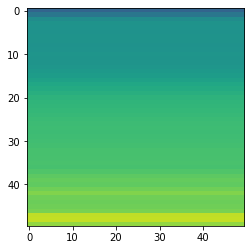

In [43]:
# COVID-19 데이터
plt.figure(figsize=(4,4))
plt.imshow(img_arr[38])
plt.show()

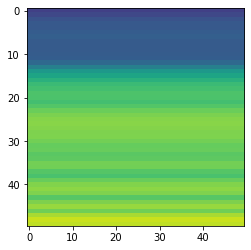

In [44]:
# symptomatic 데이터
plt.figure(figsize=(4,4))
plt.imshow(img_arr[0])
plt.show()

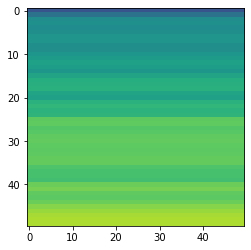

In [45]:
# healthy 데이터
plt.figure(figsize=(4,4))
plt.imshow(img_arr[1])
plt.show()

### Spectrogram plot 2

In [46]:
def graph_spectrogram_2(wav_file, hop_length = 512, n_fft = 1024, sr=16000):

    sig, sr = librosa.load(wav_file, sr=sr)
    
    hop_length_duration = float(hop_length) / sr
    n_fft_duration = float(n_fft) / sr
    stft = librosa.stft(sig, n_fft=n_fft, hop_length=hop_length)
    magnitude = np.abs(stft)
    log_spectrogram = librosa.amplitude_to_db(magnitude)
    
    fig,ax = plt.subplots(1)
    fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
    ax.axis('off')
    librosa.display.specshow(log_spectrogram, sr=sr, hop_length=hop_length)
    ax.axis('off')
    plt.rcParams['figure.figsize'] = [0.75,0.5]
    fig.canvas.draw()
    size_inches  = fig.get_size_inches()
    dpi          = fig.get_dpi()
    width, height = fig.get_size_inches() * fig.get_dpi()
    
    mplimage = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    imarray = np.reshape(mplimage, (int(height), int(width), 3))
    plt.close(fig)
    return imarray

In [47]:
# rgb 이미지 불러오기
imgs = []
for idx in range(len(files)):
    imgs.append(graph_spectrogram_2(files[idx]))

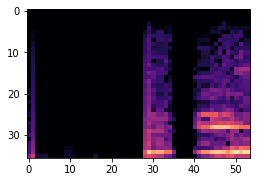

In [48]:
# COVID-19 데이터
plt.figure(figsize=(4,4))
plt.imshow(imgs[38])
plt.show()

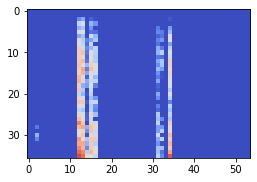

In [49]:
# symptomatic 데이터
plt.figure(figsize=(4,4))
plt.imshow(imgs[0])
plt.show()

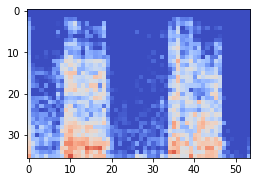

In [50]:
# healthy 데이터
plt.figure(figsize=(4,4))
plt.imshow(imgs[1])
plt.show()

In [51]:
def graph_spectrogram_3(wav_file, sr=16000):
    
    sig, sr = librosa.load(wav_file, sr=sr)
    n_fft = 512
    win_length = 400
    hop_length = 160
    n_mels = 80

    D = np.abs(librosa.stft(sig, n_fft=n_fft, win_length = win_length, hop_length=hop_length))
    mel_spec = librosa.feature.melspectrogram(S=D, sr=sr, n_mels=n_mels, hop_length=hop_length, win_length=win_length)
    
    fig,ax = plt.subplots(1)
    fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
    ax.axis('off')
    librosa.display.specshow(librosa.amplitude_to_db(mel_spec, ref=0.00002), sr=sr, hop_length = hop_length, cmap = plt.cm.jet)
    ax.axis('off')
    plt.rcParams['figure.figsize'] = [0.75,0.5]
    fig.canvas.draw()
    size_inches  = fig.get_size_inches()
    dpi          = fig.get_dpi()
    width, height = fig.get_size_inches() * fig.get_dpi()
    
    mplimage = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    imarray = np.reshape(mplimage, (int(height), int(width), 3))
    plt.close(fig)
    return imarray

In [52]:
# rgb 이미지 불러오기
imgss = []
for idx in range(len(files)):
    imgss.append(graph_spectrogram_3(files[idx]))

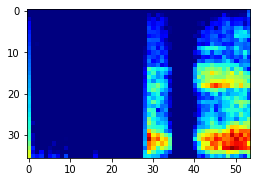

In [53]:
# COVID-19 데이터
plt.figure(figsize=(4,4))
plt.imshow(imgss[38])
plt.show()

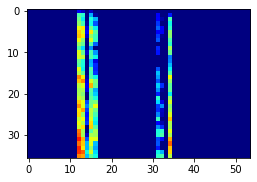

In [54]:
# symptomatic 데이터
plt.figure(figsize=(4,4))
plt.imshow(imgss[0])
plt.show()

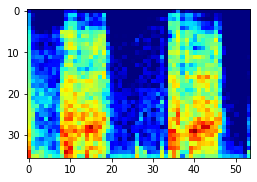

In [55]:
# healthy 데이터
plt.figure(figsize=(4,4))
plt.imshow(imgss[1])
plt.show()

In [83]:
# 1
img_arr = np.array(img)
# 2
img_arr2 = np.array(imgs)
# 3
img_arr3 = np.array(imgss)

### train-test set

In [210]:
# Train data 80% : test data 20%로 나눕니다.
X_train, X_test, y_train, y_test = train_test_split(img_arr3, np.array(metadata_res['status']), test_size=0.2, shuffle=False)

X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

In [211]:
X_train.shape

(7000, 36, 54, 3)

In [212]:
y_train.shape

(7000, 3)

### under sampling

In [214]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
dataForSmote = X_train.reshape(7000, 36 * 54 * 3)
X_smote, y_smote = sm.fit_resample(X_train, y_train)

AttributeError: 'DataFrame' object has no attribute 'argmax'

In [195]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [197]:
print(np.array(metadata_res['status']))
print(y_train)
print(y_test)

['healthy' 'healthy' 'healthy' ... 'healthy' 'healthy' 'symptomatic']
[[0 1 0]
 [0 1 0]
 [0 1 0]
 ...
 [0 1 0]
 [0 1 0]
 [1 0 0]]
[[0 1 0]
 [0 1 0]
 [0 0 1]
 ...
 [0 1 0]
 [0 1 0]
 [0 0 1]]


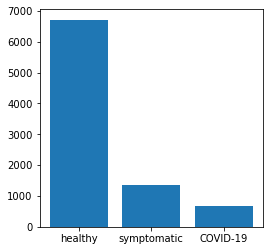

In [198]:
plt.figure(figsize=(4,4))
plt.bar(metadata_res['status'].value_counts().index, metadata_res['status'].value_counts())
plt.show()

In [199]:
metadata_res['status'].value_counts()

healthy        6717
symptomatic    1362
COVID-19        671
Name: status, dtype: int64

In [200]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(36,54,3)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 34, 52, 32)        896       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 25, 64)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 16, 25, 64)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 25600)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               3276928   
_________________________________________________________________
dropout_17 (Dropout)         (None, 128)              

In [201]:
import tensorflow
opt = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=[tensorflow.keras.metrics.Precision(name='precision'),
                                                                       tensorflow.keras.metrics.Recall(name='recall'),
                                                                      tensorflow.keras.metrics.FalsePositives(name='false_positives'),
                                                                      tensorflow.keras.metrics.FalseNegatives(name='false_negatives')])

In [202]:
history = model.fit(X_train, y_train, batch_size=64, epochs=32, verbose=1, validation_data=(X_test, y_test))

AttributeError: 'BalancedDataGenerator' object has no attribute 'shape'

In [100]:
CLASSES = np.array(['COVID-19','healthy','symptomatic'])

pred = model.predict(X_test)
pred_single = CLASSES[np.argmax(pred, axis=-1)]
actual_single = CLASSES[np.argmax(y_test, axis=-1)]

In [107]:
resultss = pd.DataFrame(pred_single,columns=['aa'])

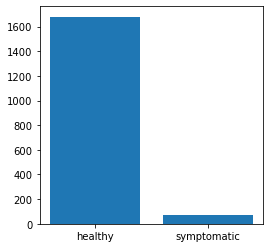

In [109]:
plt.figure(figsize=(4,4))
plt.bar(resultss['aa'].value_counts().index, resultss['aa'].value_counts())
plt.show()

In [110]:
resultss['aa'].value_counts()

healthy        1680
symptomatic      70
Name: aa, dtype: int64

In [118]:
from sklearn.metrics import confusion_matrix
confusion_matrix(actual_single,pred_single,labels=['COVID-19','healthy','symptomatic'])

array([[   0,  128,    6],
       [   0, 1294,   53],
       [   0,  258,   11]], dtype=int64)

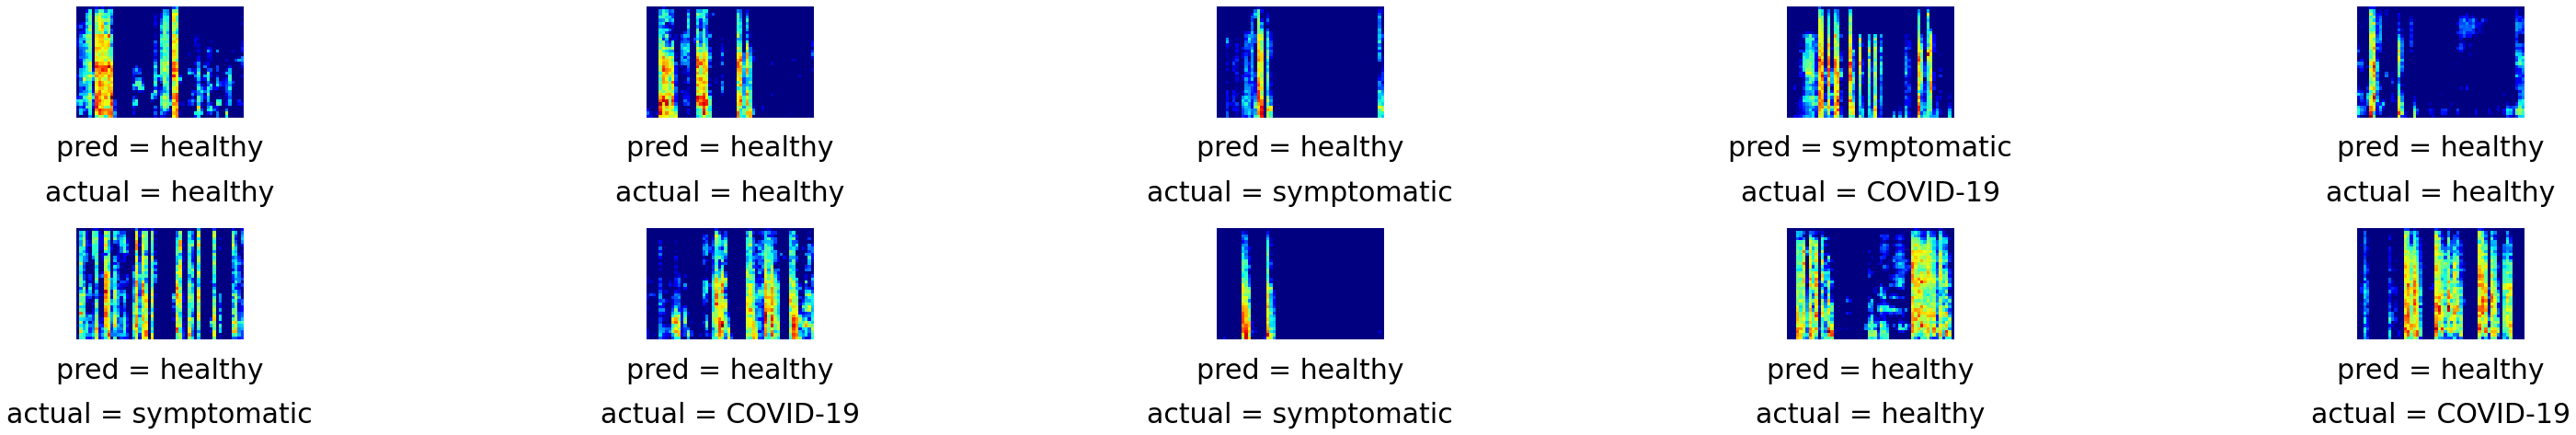

In [111]:
show_n = 10
indices = np.random.choice(range(len(X_test)),show_n)

fig = plt.figure(figsize=(50, 20))
fig.subplots_adjust(hspace = 1, wspace = 1)

for i, idx in enumerate(indices):
    imgsaa = X_test[idx]
    ax = fig.add_subplot(5, show_n/2, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, 'pred = ' + str(pred_single[idx]), fontsize=30, ha ='center', transform = ax.transAxes)
    ax.text(0.5, -0.75, 'actual = ' + str(actual_single[idx]), fontsize=30, ha ='center', transform = ax.transAxes)
    ax.imshow(imgsaa)